In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision 
import torch.nn as nn
import torchvision.transforms as transforms
from datetime import datetime
from torchsummary import summary

In [2]:
train_dataset = torchvision.datasets.SVHN('.',split='train', transform=transforms.ToTensor(), download=True)

In [3]:
test_dataset = torchvision.datasets.SVHN('.',split='test', transform=transforms.ToTensor(), download=True)

In [4]:
train_dataset.data.max()


255

 <!-- 1. convolution, kernel_size=5, channels=6, stride=1, padding=2
 2. batch-normalization
 3. ReLU
 4. Max-pool, kernel_size=2, stride=2

 5. convolution, kernel_size=3, channels=12, stride=1, padding=1
 6. batch-normalization
 7. ReLU
 8. Max-pool, kernel_size=2, stride=2

 9. convolution, kernel_size=3, channels=24, stride=1, padding=1
 10. batch-normalization
 11. ReLU
 12. Max-pool, kernel_size=2, stride=2

 13. fully connected layer, output_size=10 -->

In [5]:
np.unique(train_dataset.labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6,kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(num_features=6),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=6, out_channels=12,kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=12),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(in_channels=12, out_channels=24,kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=24),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.flatten = nn.Flatten()

    self.dense = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=384,out_features=512),
        nn.LeakyReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=512,out_features=10))

  def forward(self, X):
    output = self.conv_layer1(X)
    output = self.conv_layer2(output)
    output = self.conv_layer3(output)
    output = self.flatten(output)
    output = self.dense(output)
    return output

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = CNN(K=10).to(device)

summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             456
       BatchNorm2d-2            [-1, 6, 32, 32]              12
              ReLU-3            [-1, 6, 32, 32]               0
         MaxPool2d-4            [-1, 6, 16, 16]               0
            Conv2d-5           [-1, 12, 16, 16]             660
       BatchNorm2d-6           [-1, 12, 16, 16]              24
              ReLU-7           [-1, 12, 16, 16]               0
         MaxPool2d-8             [-1, 12, 8, 8]               0
            Conv2d-9             [-1, 24, 8, 8]           2,616
      BatchNorm2d-10             [-1, 24, 8, 8]              48
             ReLU-11             [-1, 24, 8, 8]               0
        MaxPool2d-12             [-1, 24, 4, 4]               0
          Flatten-13                  [-1, 384]               0
          Dropout-14                  [

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for epoch in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []

    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model.forward(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    
    train_loss = np.mean(train_loss)

    test_loss =[]

    model.eval()
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    dt = datetime.now() - t0

    print(f'Epoch {epoch+1} of {epochs}, Train loss {train_loss:.4f}, Test loss {test_loss:.4f}, Duration {dt}')
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss

  return train_losses, test_losses

In [11]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=10)

Epoch 1 of 10, Train loss 0.9096, Test loss 0.6395, Duration 0:00:21.640501
Epoch 2 of 10, Train loss 0.5462, Test loss 0.4572, Duration 0:00:21.666571
Epoch 3 of 10, Train loss 0.4722, Test loss 0.4483, Duration 0:00:21.402692
Epoch 4 of 10, Train loss 0.4297, Test loss 0.3809, Duration 0:00:21.522835
Epoch 5 of 10, Train loss 0.4020, Test loss 0.3623, Duration 0:00:21.510781
Epoch 6 of 10, Train loss 0.3770, Test loss 0.3767, Duration 0:00:21.552744
Epoch 7 of 10, Train loss 0.3619, Test loss 0.3427, Duration 0:00:21.565525
Epoch 8 of 10, Train loss 0.3445, Test loss 0.3498, Duration 0:00:21.477591
Epoch 9 of 10, Train loss 0.3336, Test loss 0.3292, Duration 0:00:21.525104
Epoch 10 of 10, Train loss 0.3166, Test loss 0.3177, Duration 0:00:21.469722


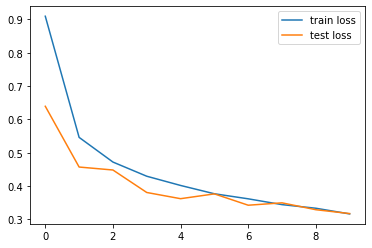

In [12]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [13]:
n_correct = 0.
n_total = 0.

model.eval()
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions==targets).sum()
  n_total += targets.shape[0]

train_acc = n_correct/n_total

n_correct = 0.
n_total = 0.

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions==targets).sum()
  n_total += targets.shape[0]

test_acc = n_correct/n_total


print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

Train accuracy: 0.9319, Test accuracy: 0.9103
